# Regularization layers

Some code borrowed from [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

# selecting one of the 4 gpus randomly
device = torch.device(f'cuda:{np.random.randint(4)}')
print(device)

cuda:2


Note: if you get GPU out of memory errors later in the code and you believe your model isn't that heavy, check out the available GPU memory on other devices by invoking the command:

```
!nvidia-smi
```

Then, select the suitable GPU (0, 1, 2 or 3). E.g. if you want to select GPU 2, run this:

```
device = torch.device('cuda:2')
```

## Getting the dataset (CIFAR-10)

Here we'll download and open the data from the CIFAR-10 datset. (For more details see [this link](https://pytorch.org/docs/stable/torchvision/datasets.html).)

In [2]:
transform = transforms.ToTensor()

BATCH_SIZE = 256

trainset = torchvision.datasets.CIFAR10(
    root='../../../share/2.8_NetworkRegularization/data/',
    train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='../../../share/2.8_NetworkRegularization/data/',
    train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import matplotlib

[['truck' 'bird' 'plane' 'plane']
 ['ship' 'dog' 'frog' 'frog']
 ['dog' 'dog' 'car' 'cat']
 ['cat' 'car' 'plane' 'horse']]


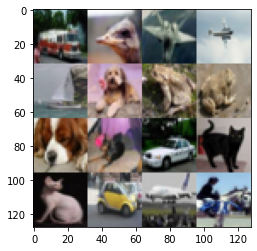

In [4]:
batch_x, batch_y = next(iter(trainloader))
batch_x = batch_x[:16]
batch_y = batch_y[:16]

plt.imshow(
    batch_x.permute(0, 2, 3, 1).reshape(4, 4, 32, 32, 3).permute(0, 2, 1, 3, 4).reshape(128, 128, 3)
)
print(
    np.array(classes)[batch_y.numpy()].reshape(4, 4)
)

## Defining the model

In [5]:
import torch.nn as nn
import torch.nn.functional as F


# We are going to build a model from several convolutional blocks.
# I.e. it's going to be:
#
#       [Conv2d -> Conv2d -> MaxPool2d] x 4
#     
# So why don't we define such a block as a separate Module?
class ConvBlock(nn.Module):
    def __init__(self,
                 in_channels,     # <== number of input channels to the 1st convolution
                 interm_channels, # <== outputs of the 1st / inputs of the 2nd convolution
                 out_channels,    # <== outputs of the 2nd convolution
                 use_batchnorm,   # <== whether we'll use batchnorm
                 initialization): # <== function that'll initialize the weights
        # First we run the base class constructor
        super(ConvBlock, self).__init__()

        # And then define all the layers used within a block
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=interm_channels,
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=interm_channels,
                               out_channels=out_channels,
                               kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.use_batchnorm = use_batchnorm
        if use_batchnorm:
            self.bn1 = nn.BatchNorm2d(interm_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)

        # If initialization function provided, call it on the weights of the model
        if initialization is not None:
            initialization(self.conv1.weight)
            initialization(self.conv2.weight)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = F.relu(x)

        x = self.pool(x)
        return x

# The model itself:
class Net(nn.Module):
    def __init__(self, use_batchnorm, initialization):
        super(Net, self).__init__()

        # Convolutional layers:                                         # 3x32x32 (Channels x height x width)
        self.conv1 = ConvBlock(3, 8, 16, use_batchnorm, initialization) # -> 8x32x32 -> 16x32x32 -> 16x16x16
        self.conv2 = ConvBlock(16, 16, 32, use_batchnorm, initialization) # -> 16x16x16 -> 32x16x16 -> 32x8x8
        self.conv3 = ConvBlock(32, 32, 64, use_batchnorm, initialization) # -> 32x8x8 -> 64x8x8 -> 64x4x4
        self.conv4 = ConvBlock(64, 64, 128, use_batchnorm, initialization) # -> 64x4x4 -> 128x4x4 -> 128x2x2

        # Fully connected layers:
        self.fc1 = nn.Linear(128 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 10)

        # If initialization function provided, call it on the weights of the model
        if initialization is not None:
            initialization(self.fc1.weight)
            initialization(self.fc2.weight)
            initialization(self.fc3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.shape[0], 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [6]:
import torch.optim as optim
from tqdm import tqdm

loss_fn = nn.CrossEntropyLoss() # softmax + neg. log likelihood

def train_model(model, epochs=3, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    test_loss = []
    test_accuracy = []
    for epoch in range(epochs):
        model.train() # train mode (affects batchnorm layers:
                      # in the subsequent forward passes they'll
                      # exhibit 'train' behaviour, i.e. they'll
                      # normalize activations over batches)
        for i, (X, y) in enumerate(tqdm(trainloader)):
            X, y = X.to(device), y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.item())

        model.eval() # test mode (affects batchnorm layers:
                     # in the subsequent forward passes they'll
                     # exhibit 'test' behaviour, i.e. they'll
                     # use the accumulated running statistics
                     # to normalize activations)
        epoch_losses = []
        epoch_accuracies = []
        with torch.no_grad(): # avoid calculating gradients during evaluation
            for X, y in testloader:
                X, y = X.to(device), y.to(device)

                pred = model(X)

                epoch_losses.append(loss_fn(pred, y).item())
                _, pred = torch.max(pred.data, 1) # pred = index of maximal output along axis=1
                epoch_accuracies.append(
                    (pred == y).to(torch.float32).mean().item()
                )
        test_loss.append(np.mean(epoch_losses))
        test_accuracy.append(np.mean(epoch_accuracies))

    return dict(
        train_loss=train_loss,
        test_loss=test_loss,
        test_accuracy=test_accuracy
    )

## Experiments

In [7]:
configurations = dict(
    fixed_normal_init=dict(
        use_batchnorm=False,
        initialization=(lambda w: w.data.normal_(std=0.001))
    ),
    he_normal_init=dict(
        use_batchnorm=False,
        initialization=(lambda w: torch.nn.init.kaiming_normal_(w, nonlinearity='relu'))
    ),
    he_normal_init_with_batchnorm=dict(
        use_batchnorm=True,
        initialization=(lambda w: torch.nn.init.kaiming_normal_(w, nonlinearity='relu'))
    )
)


                                                 # the '**' notation transforms the dictionary
                                                 # into keyword arguments, as if we called:
result = {                                       # Net(use_batchnorm=config['use_batchnorm'],
    name : train_model(Net(**config).to(device)) #     initialization=config['initialization'])
    for name, config in configurations.items()
} # train the defined configurations, 
  # get the result as a dictionary

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:34,  5.58it/s]

  2%|▏         | 4/196 [00:00<00:26,  7.16it/s]

  4%|▎         | 7/196 [00:00<00:20,  9.00it/s]

  5%|▌         | 10/196 [00:00<00:16, 11.10it/s]

  7%|▋         | 13/196 [00:00<00:13, 13.36it/s]

  8%|▊         | 16/196 [00:00<00:11, 15.77it/s]

 10%|▉         | 19/196 [00:00<00:09, 17.89it/s]

 11%|█         | 22/196 [00:01<00:08, 20.29it/s]

 13%|█▎        | 25/196 [00:01<00:07, 22.44it/s]

 14%|█▍        | 28/196 [00:01<00:06, 24.17it/s]

 16%|█▌        | 31/196 [00:01<00:06, 25.55it/s]

 17%|█▋        | 34/196 [00:01<00:06, 25.48it/s]

 19%|█▉        | 37/196 [00:01<00:06, 26.36it/s]

 20%|██        | 40/196 [00:01<00:05, 27.24it/s]

 22%|██▏       | 43/196 [00:01<00:05, 27.88it/s]

 23%|██▎       | 46/196 [00:01<00:05, 28.36it/s]

 25%|██▌       | 49/196 [00:01<00:05, 28.78it/s]

 27%|██▋       | 52/196 [00:02<00:04, 28.96it/s]

 28%|██▊       | 55/196 [00:02<00:04, 29.13it/s]

 30%|██▉       | 58/196 [00:02<00:04, 29.31it/s]

 31%|███       | 61/196 [00:02<00:04, 28.95it/s]

 33%|███▎      | 64/196 [00:02<00:04, 28.69it/s]

 34%|███▍      | 67/196 [00:02<00:04, 28.23it/s]

 36%|███▌      | 70/196 [00:02<00:04, 28.70it/s]

 37%|███▋      | 73/196 [00:02<00:04, 28.97it/s]

 39%|███▉      | 76/196 [00:02<00:04, 28.08it/s]

 40%|████      | 79/196 [00:03<00:04, 28.53it/s]

 42%|████▏     | 82/196 [00:03<00:04, 27.69it/s]

 43%|████▎     | 85/196 [00:03<00:03, 28.18it/s]

 45%|████▍     | 88/196 [00:03<00:03, 28.55it/s]

 46%|████▋     | 91/196 [00:03<00:03, 28.85it/s]

 48%|████▊     | 94/196 [00:03<00:03, 28.99it/s]

 49%|████▉     | 97/196 [00:03<00:03, 27.97it/s]

 51%|█████     | 100/196 [00:03<00:03, 27.82it/s]

 53%|█████▎    | 103/196 [00:03<00:03, 28.31it/s]

 54%|█████▍    | 106/196 [00:03<00:03, 28.74it/s]

 56%|█████▌    | 109/196 [00:04<00:02, 29.00it/s]

 57%|█████▋    | 112/196 [00:04<00:03, 27.55it/s]

 59%|█████▊    | 115/196 [00:04<00:02, 28.18it/s]

 60%|██████    | 118/196 [00:04<00:02, 28.00it/s]

 62%|██████▏   | 121/196 [00:04<00:02, 28.51it/s]

 63%|██████▎   | 124/196 [00:04<00:02, 28.80it/s]

 65%|██████▍   | 127/196 [00:04<00:02, 29.04it/s]

 66%|██████▋   | 130/196 [00:04<00:02, 29.18it/s]

 68%|██████▊   | 134/196 [00:04<00:02, 29.40it/s]

 70%|██████▉   | 137/196 [00:05<00:02, 29.11it/s]

 71%|███████▏  | 140/196 [00:05<00:01, 28.47it/s]

 73%|███████▎  | 143/196 [00:05<00:01, 28.04it/s]

 74%|███████▍  | 146/196 [00:05<00:01, 28.58it/s]

 76%|███████▌  | 149/196 [00:05<00:01, 28.84it/s]

 78%|███████▊  | 152/196 [00:05<00:01, 29.02it/s]

 79%|███████▉  | 155/196 [00:05<00:01, 29.11it/s]

 81%|████████  | 158/196 [00:05<00:01, 29.33it/s]

 82%|████████▏ | 161/196 [00:05<00:01, 29.42it/s]

 84%|████████▎ | 164/196 [00:05<00:01, 28.16it/s]

 85%|████████▌ | 167/196 [00:06<00:01, 28.45it/s]

 87%|████████▋ | 170/196 [00:06<00:00, 28.46it/s]

 88%|████████▊ | 173/196 [00:06<00:00, 28.75it/s]

 90%|████████▉ | 176/196 [00:06<00:00, 22.67it/s]

 91%|█████████▏| 179/196 [00:06<00:00, 24.34it/s]

 93%|█████████▎| 182/196 [00:06<00:00, 25.69it/s]

 94%|█████████▍| 185/196 [00:06<00:00, 26.78it/s]

 96%|█████████▌| 188/196 [00:06<00:00, 27.49it/s]

 97%|█████████▋| 191/196 [00:06<00:00, 28.09it/s]

 99%|█████████▉| 194/196 [00:07<00:00, 27.34it/s]

100%|██████████| 196/196 [00:07<00:00, 27.25it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:31,  6.27it/s]

  2%|▏         | 3/196 [00:00<00:24,  7.90it/s]

  3%|▎         | 6/196 [00:00<00:18, 10.08it/s]

  5%|▍         | 9/196 [00:00<00:14, 12.55it/s]

  6%|▌         | 12/196 [00:00<00:12, 15.18it/s]

  8%|▊         | 15/196 [00:00<00:10, 17.76it/s]

  9%|▉         | 18/196 [00:00<00:08, 20.19it/s]

 11%|█         | 21/196 [00:00<00:08, 20.97it/s]

 12%|█▏        | 24/196 [00:01<00:07, 23.00it/s]

 14%|█▍        | 27/196 [00:01<00:06, 24.64it/s]

 15%|█▌        | 30/196 [00:01<00:06, 25.92it/s]

 17%|█▋        | 33/196 [00:01<00:06, 26.87it/s]

 18%|█▊        | 36/196 [00:01<00:05, 27.67it/s]

 20%|█▉        | 39/196 [00:01<00:05, 27.08it/s]

 21%|██▏       | 42/196 [00:01<00:05, 27.28it/s]

 23%|██▎       | 45/196 [00:01<00:05, 27.93it/s]

 24%|██▍       | 48/196 [00:01<00:05, 28.48it/s]

 26%|██▌       | 51/196 [00:01<00:05, 28.81it/s]

 28%|██▊       | 54/196 [00:02<00:04, 29.07it/s]

 29%|██▉       | 57/196 [00:02<00:04, 29.23it/s]

 31%|███       | 60/196 [00:02<00:04, 29.42it/s]

 32%|███▏      | 63/196 [00:02<00:04, 28.81it/s]

 34%|███▎      | 66/196 [00:02<00:04, 27.65it/s]

 35%|███▌      | 69/196 [00:02<00:04, 28.26it/s]

 37%|███▋      | 72/196 [00:02<00:04, 28.72it/s]

 38%|███▊      | 75/196 [00:02<00:04, 29.02it/s]

 40%|███▉      | 78/196 [00:02<00:04, 29.28it/s]

 41%|████▏     | 81/196 [00:02<00:03, 29.39it/s]

 43%|████▎     | 84/196 [00:03<00:03, 29.50it/s]

 44%|████▍     | 87/196 [00:03<00:03, 28.87it/s]

 46%|████▌     | 90/196 [00:03<00:03, 27.68it/s]

 47%|████▋     | 93/196 [00:03<00:03, 28.22it/s]

 49%|████▉     | 96/196 [00:03<00:03, 28.68it/s]

 51%|█████     | 99/196 [00:03<00:03, 29.02it/s]

 52%|█████▏    | 102/196 [00:03<00:03, 29.18it/s]

 54%|█████▎    | 105/196 [00:03<00:03, 29.26it/s]

 55%|█████▌    | 108/196 [00:03<00:03, 28.72it/s]

 57%|█████▋    | 111/196 [00:04<00:02, 29.07it/s]

 58%|█████▊    | 114/196 [00:04<00:02, 29.25it/s]

 60%|█████▉    | 117/196 [00:04<00:02, 27.93it/s]

 61%|██████    | 120/196 [00:04<00:02, 28.47it/s]

 63%|██████▎   | 123/196 [00:04<00:02, 28.86it/s]

 64%|██████▍   | 126/196 [00:04<00:02, 29.08it/s]

 66%|██████▌   | 129/196 [00:04<00:02, 29.19it/s]

 67%|██████▋   | 132/196 [00:04<00:02, 29.41it/s]

 69%|██████▉   | 135/196 [00:04<00:02, 29.44it/s]

 70%|███████   | 138/196 [00:04<00:02, 27.52it/s]

 72%|███████▏  | 141/196 [00:05<00:01, 28.13it/s]

 73%|███████▎  | 144/196 [00:05<00:01, 28.59it/s]

 75%|███████▌  | 147/196 [00:05<00:01, 27.72it/s]

 77%|███████▋  | 150/196 [00:05<00:01, 27.26it/s]

 78%|███████▊  | 153/196 [00:05<00:01, 27.85it/s]

 80%|███████▉  | 156/196 [00:05<00:01, 28.41it/s]

 81%|████████  | 159/196 [00:05<00:01, 28.80it/s]

 83%|████████▎ | 162/196 [00:05<00:01, 24.40it/s]

 84%|████████▍ | 165/196 [00:05<00:01, 25.76it/s]

 86%|████████▌ | 168/196 [00:06<00:01, 26.86it/s]

 87%|████████▋ | 171/196 [00:06<00:00, 26.05it/s]

 89%|████████▉ | 174/196 [00:06<00:00, 26.70it/s]

 90%|█████████ | 177/196 [00:06<00:00, 25.29it/s]

 92%|█████████▏| 180/196 [00:06<00:00, 24.96it/s]

 93%|█████████▎| 183/196 [00:06<00:00, 25.66it/s]

 95%|█████████▍| 186/196 [00:06<00:00, 26.69it/s]

 96%|█████████▋| 189/196 [00:06<00:00, 27.47it/s]

 98%|█████████▊| 192/196 [00:06<00:00, 27.88it/s]

 99%|█████████▉| 195/196 [00:07<00:00, 28.34it/s]

100%|██████████| 196/196 [00:07<00:00, 27.54it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:30,  6.39it/s]

  2%|▏         | 4/196 [00:00<00:23,  8.29it/s]

  4%|▎         | 7/196 [00:00<00:18, 10.33it/s]

  5%|▌         | 10/196 [00:00<00:14, 12.73it/s]

  7%|▋         | 13/196 [00:00<00:11, 15.36it/s]

  8%|▊         | 16/196 [00:00<00:10, 17.98it/s]

 10%|▉         | 19/196 [00:00<00:08, 20.36it/s]

 11%|█         | 22/196 [00:00<00:07, 22.46it/s]

 13%|█▎        | 25/196 [00:01<00:07, 24.24it/s]

 14%|█▍        | 28/196 [00:01<00:06, 25.64it/s]

 16%|█▌        | 31/196 [00:01<00:06, 24.96it/s]

 17%|█▋        | 34/196 [00:01<00:06, 26.11it/s]

 19%|█▉        | 37/196 [00:01<00:05, 27.07it/s]

 20%|██        | 40/196 [00:01<00:05, 26.05it/s]

 22%|██▏       | 43/196 [00:01<00:05, 26.93it/s]

 23%|██▎       | 46/196 [00:01<00:05, 27.66it/s]

 25%|██▌       | 49/196 [00:01<00:05, 28.10it/s]

 27%|██▋       | 52/196 [00:01<00:05, 28.45it/s]

 28%|██▊       | 55/196 [00:02<00:04, 28.48it/s]

 30%|██▉       | 58/196 [00:02<00:05, 27.23it/s]

 31%|███       | 61/196 [00:02<00:04, 27.82it/s]

 33%|███▎      | 64/196 [00:02<00:04, 28.25it/s]

 34%|███▍      | 67/196 [00:02<00:04, 28.58it/s]

 36%|███▌      | 70/196 [00:02<00:04, 28.88it/s]

 37%|███▋      | 73/196 [00:02<00:04, 27.94it/s]

 39%|███▉      | 76/196 [00:02<00:04, 27.60it/s]

 40%|████      | 79/196 [00:02<00:04, 28.12it/s]

 42%|████▏     | 82/196 [00:03<00:04, 24.24it/s]

 43%|████▎     | 85/196 [00:03<00:04, 23.77it/s]

 45%|████▍     | 88/196 [00:03<00:04, 25.21it/s]

 46%|████▋     | 91/196 [00:03<00:03, 26.41it/s]

 48%|████▊     | 94/196 [00:03<00:04, 25.27it/s]

 49%|████▉     | 97/196 [00:03<00:03, 26.30it/s]

 51%|█████     | 100/196 [00:03<00:03, 27.13it/s]

 53%|█████▎    | 103/196 [00:03<00:03, 24.89it/s]

 54%|█████▍    | 106/196 [00:04<00:03, 25.69it/s]

 56%|█████▌    | 109/196 [00:04<00:03, 26.21it/s]

 57%|█████▋    | 112/196 [00:04<00:03, 27.06it/s]

 59%|█████▊    | 115/196 [00:04<00:02, 27.61it/s]

 60%|██████    | 118/196 [00:04<00:02, 28.10it/s]

 62%|██████▏   | 121/196 [00:04<00:03, 24.49it/s]

 63%|██████▎   | 124/196 [00:04<00:02, 25.01it/s]

 65%|██████▍   | 127/196 [00:04<00:02, 26.20it/s]

 66%|██████▋   | 130/196 [00:04<00:02, 26.08it/s]

 68%|██████▊   | 133/196 [00:05<00:02, 27.11it/s]

 69%|██████▉   | 136/196 [00:05<00:02, 27.72it/s]

 71%|███████   | 139/196 [00:05<00:02, 28.13it/s]

 72%|███████▏  | 142/196 [00:05<00:01, 28.66it/s]

 74%|███████▍  | 145/196 [00:05<00:01, 28.96it/s]

 76%|███████▌  | 148/196 [00:05<00:01, 27.22it/s]

 77%|███████▋  | 151/196 [00:05<00:01, 27.83it/s]

 79%|███████▊  | 154/196 [00:05<00:01, 28.34it/s]

 80%|████████  | 157/196 [00:05<00:01, 27.19it/s]

 82%|████████▏ | 160/196 [00:05<00:01, 27.21it/s]

 83%|████████▎ | 163/196 [00:06<00:01, 27.81it/s]

 85%|████████▍ | 166/196 [00:06<00:01, 28.30it/s]

 86%|████████▌ | 169/196 [00:06<00:00, 28.69it/s]

 88%|████████▊ | 172/196 [00:06<00:00, 26.90it/s]

 89%|████████▉ | 175/196 [00:06<00:00, 27.63it/s]

 91%|█████████ | 178/196 [00:06<00:00, 28.18it/s]

 92%|█████████▏| 181/196 [00:06<00:00, 28.64it/s]

 94%|█████████▍| 184/196 [00:06<00:00, 28.92it/s]

 95%|█████████▌| 187/196 [00:06<00:00, 29.12it/s]

 97%|█████████▋| 190/196 [00:07<00:00, 29.38it/s]

 98%|█████████▊| 193/196 [00:07<00:00, 29.41it/s]

100%|██████████| 196/196 [00:07<00:00, 27.02it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:27,  7.07it/s]

  2%|▏         | 4/196 [00:00<00:21,  9.07it/s]

  4%|▎         | 7/196 [00:00<00:16, 11.12it/s]

  5%|▌         | 10/196 [00:00<00:13, 13.62it/s]

  7%|▋         | 13/196 [00:00<00:11, 16.25it/s]

  8%|▊         | 16/196 [00:00<00:09, 18.79it/s]

 10%|▉         | 19/196 [00:00<00:08, 21.08it/s]

 11%|█         | 22/196 [00:00<00:07, 23.14it/s]

 13%|█▎        | 25/196 [00:00<00:06, 24.47it/s]

 14%|█▍        | 28/196 [00:01<00:06, 25.77it/s]

 16%|█▌        | 31/196 [00:01<00:06, 26.65it/s]

 17%|█▋        | 34/196 [00:01<00:06, 26.35it/s]

 19%|█▉        | 37/196 [00:01<00:05, 27.25it/s]

 20%|██        | 40/196 [00:01<00:05, 27.85it/s]

 22%|██▏       | 43/196 [00:01<00:05, 28.30it/s]

 23%|██▎       | 46/196 [00:01<00:05, 27.81it/s]

 25%|██▌       | 49/196 [00:01<00:05, 27.32it/s]

 27%|██▋       | 52/196 [00:01<00:05, 27.99it/s]

 28%|██▊       | 55/196 [00:02<00:04, 28.31it/s]

 30%|██▉       | 58/196 [00:02<00:04, 28.58it/s]

 31%|███       | 61/196 [00:02<00:04, 28.94it/s]

 33%|███▎      | 64/196 [00:02<00:04, 29.17it/s]

 34%|███▍      | 67/196 [00:02<00:04, 29.28it/s]

 36%|███▌      | 70/196 [00:02<00:04, 27.77it/s]

 37%|███▋      | 73/196 [00:02<00:04, 28.07it/s]

 39%|███▉      | 76/196 [00:02<00:04, 28.50it/s]

 40%|████      | 79/196 [00:02<00:04, 28.87it/s]

 42%|████▏     | 82/196 [00:02<00:03, 29.14it/s]

 43%|████▎     | 85/196 [00:03<00:03, 29.29it/s]

 45%|████▍     | 88/196 [00:03<00:03, 28.03it/s]

 46%|████▋     | 91/196 [00:03<00:03, 27.76it/s]

 48%|████▊     | 94/196 [00:03<00:04, 23.90it/s]

 49%|████▉     | 97/196 [00:03<00:03, 25.29it/s]

 51%|█████     | 100/196 [00:03<00:03, 25.51it/s]

 53%|█████▎    | 103/196 [00:03<00:03, 25.61it/s]

 54%|█████▍    | 106/196 [00:03<00:03, 26.70it/s]

 56%|█████▌    | 109/196 [00:04<00:03, 25.39it/s]

 57%|█████▋    | 112/196 [00:04<00:03, 26.30it/s]

 59%|█████▊    | 115/196 [00:04<00:02, 27.09it/s]

 60%|██████    | 118/196 [00:04<00:02, 27.84it/s]

 62%|██████▏   | 121/196 [00:04<00:02, 27.20it/s]

 63%|██████▎   | 124/196 [00:04<00:02, 27.21it/s]

 65%|██████▍   | 127/196 [00:04<00:02, 27.76it/s]

 66%|██████▋   | 130/196 [00:04<00:02, 28.26it/s]

 68%|██████▊   | 133/196 [00:04<00:02, 26.79it/s]

 69%|██████▉   | 136/196 [00:05<00:02, 27.50it/s]

 71%|███████   | 139/196 [00:05<00:02, 28.01it/s]

 72%|███████▏  | 142/196 [00:05<00:01, 28.27it/s]

 74%|███████▍  | 145/196 [00:05<00:01, 27.47it/s]

 76%|███████▌  | 148/196 [00:05<00:01, 27.42it/s]

 77%|███████▋  | 151/196 [00:05<00:01, 27.88it/s]

 79%|███████▊  | 154/196 [00:05<00:01, 28.25it/s]

 80%|████████  | 157/196 [00:05<00:01, 28.64it/s]

 82%|████████▏ | 160/196 [00:05<00:01, 28.92it/s]

 83%|████████▎ | 163/196 [00:05<00:01, 27.23it/s]

 85%|████████▍ | 166/196 [00:06<00:01, 27.81it/s]

 86%|████████▌ | 169/196 [00:06<00:00, 28.32it/s]

 88%|████████▊ | 172/196 [00:06<00:00, 27.78it/s]

 89%|████████▉ | 175/196 [00:06<00:00, 28.07it/s]

 91%|█████████ | 178/196 [00:06<00:00, 27.74it/s]

 92%|█████████▏| 181/196 [00:06<00:00, 28.00it/s]

 94%|█████████▍| 184/196 [00:06<00:00, 27.12it/s]

 95%|█████████▌| 187/196 [00:06<00:00, 26.92it/s]

 97%|█████████▋| 190/196 [00:06<00:00, 27.47it/s]

 98%|█████████▊| 193/196 [00:07<00:00, 27.99it/s]

100%|██████████| 196/196 [00:07<00:00, 27.35it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:29,  6.70it/s]

  2%|▏         | 4/196 [00:00<00:22,  8.50it/s]

  4%|▎         | 7/196 [00:00<00:17, 10.80it/s]

  5%|▌         | 10/196 [00:00<00:14, 13.20it/s]

  7%|▋         | 13/196 [00:00<00:11, 15.82it/s]

  8%|▊         | 16/196 [00:00<00:09, 18.19it/s]

 10%|▉         | 19/196 [00:00<00:08, 20.22it/s]

 11%|█         | 22/196 [00:00<00:07, 22.31it/s]

 13%|█▎        | 25/196 [00:01<00:07, 24.05it/s]

 14%|█▍        | 28/196 [00:01<00:06, 24.38it/s]

 16%|█▌        | 31/196 [00:01<00:06, 25.19it/s]

 17%|█▋        | 34/196 [00:01<00:06, 26.34it/s]

 19%|█▉        | 37/196 [00:01<00:05, 27.15it/s]

 20%|██        | 40/196 [00:01<00:05, 27.84it/s]

 22%|██▏       | 43/196 [00:01<00:05, 27.57it/s]

 23%|██▎       | 46/196 [00:01<00:05, 27.00it/s]

 25%|██▌       | 49/196 [00:01<00:05, 27.65it/s]

 27%|██▋       | 52/196 [00:01<00:05, 28.25it/s]

 28%|██▊       | 55/196 [00:02<00:04, 28.63it/s]

 30%|██▉       | 58/196 [00:02<00:05, 27.51it/s]

 31%|███       | 61/196 [00:02<00:04, 28.10it/s]

 33%|███▎      | 64/196 [00:02<00:04, 27.95it/s]

 34%|███▍      | 67/196 [00:02<00:04, 28.49it/s]

 36%|███▌      | 70/196 [00:02<00:04, 28.78it/s]

 37%|███▋      | 73/196 [00:02<00:04, 29.10it/s]

 39%|███▉      | 76/196 [00:02<00:05, 22.87it/s]

 40%|████      | 79/196 [00:03<00:04, 24.54it/s]

 42%|████▏     | 82/196 [00:03<00:04, 23.99it/s]

 43%|████▎     | 85/196 [00:03<00:04, 25.39it/s]

 45%|████▍     | 88/196 [00:03<00:04, 26.43it/s]

 46%|████▋     | 91/196 [00:03<00:04, 25.63it/s]

 48%|████▊     | 94/196 [00:03<00:03, 26.56it/s]

 49%|████▉     | 97/196 [00:03<00:03, 27.37it/s]

 51%|█████     | 100/196 [00:03<00:03, 28.04it/s]

 53%|█████▎    | 103/196 [00:03<00:03, 26.28it/s]

 54%|█████▍    | 106/196 [00:04<00:03, 27.10it/s]

 56%|█████▌    | 109/196 [00:04<00:03, 25.69it/s]

 57%|█████▋    | 112/196 [00:04<00:03, 26.75it/s]

 59%|█████▊    | 115/196 [00:04<00:02, 27.58it/s]

 60%|██████    | 118/196 [00:04<00:02, 28.18it/s]

 62%|██████▏   | 121/196 [00:04<00:02, 28.54it/s]

 63%|██████▎   | 124/196 [00:04<00:02, 26.70it/s]

 65%|██████▍   | 127/196 [00:04<00:02, 27.60it/s]

 66%|██████▋   | 130/196 [00:04<00:02, 28.18it/s]

 68%|██████▊   | 133/196 [00:04<00:02, 28.55it/s]

 69%|██████▉   | 136/196 [00:05<00:02, 28.86it/s]

 71%|███████   | 139/196 [00:05<00:02, 27.04it/s]

 72%|███████▏  | 142/196 [00:05<00:01, 27.74it/s]

 74%|███████▍  | 145/196 [00:05<00:01, 27.14it/s]

 76%|███████▌  | 148/196 [00:05<00:01, 27.15it/s]

 77%|███████▋  | 151/196 [00:05<00:01, 27.53it/s]

 79%|███████▊  | 154/196 [00:05<00:01, 28.08it/s]

 80%|████████  | 157/196 [00:05<00:01, 27.38it/s]

 82%|████████▏ | 160/196 [00:05<00:01, 26.98it/s]

 83%|████████▎ | 163/196 [00:06<00:01, 27.71it/s]

 85%|████████▍ | 166/196 [00:06<00:01, 28.10it/s]

 86%|████████▌ | 169/196 [00:06<00:00, 28.52it/s]

 88%|████████▊ | 172/196 [00:06<00:00, 26.82it/s]

 89%|████████▉ | 175/196 [00:06<00:00, 27.59it/s]

 91%|█████████ | 178/196 [00:06<00:00, 27.99it/s]

 92%|█████████▏| 181/196 [00:06<00:00, 28.47it/s]

 94%|█████████▍| 184/196 [00:06<00:00, 28.77it/s]

 95%|█████████▌| 187/196 [00:06<00:00, 27.11it/s]

 97%|█████████▋| 190/196 [00:07<00:00, 27.76it/s]

 98%|█████████▊| 193/196 [00:07<00:00, 28.34it/s]

100%|██████████| 196/196 [00:07<00:00, 27.02it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:27,  7.08it/s]

  2%|▏         | 4/196 [00:00<00:22,  8.71it/s]

  4%|▎         | 7/196 [00:00<00:17, 11.02it/s]

  5%|▌         | 10/196 [00:00<00:14, 13.23it/s]

  7%|▋         | 13/196 [00:00<00:11, 15.70it/s]

  8%|▊         | 16/196 [00:00<00:09, 18.17it/s]

 10%|▉         | 19/196 [00:00<00:08, 19.76it/s]

 11%|█         | 22/196 [00:00<00:08, 21.62it/s]

 13%|█▎        | 25/196 [00:01<00:07, 23.50it/s]

 14%|█▍        | 28/196 [00:01<00:06, 24.87it/s]

 16%|█▌        | 31/196 [00:01<00:06, 26.10it/s]

 17%|█▋        | 34/196 [00:01<00:05, 27.02it/s]

 19%|█▉        | 37/196 [00:01<00:05, 27.24it/s]

 20%|██        | 40/196 [00:01<00:05, 26.87it/s]

 22%|██▏       | 43/196 [00:01<00:05, 27.59it/s]

 23%|██▎       | 46/196 [00:01<00:05, 28.23it/s]

 25%|██▌       | 49/196 [00:01<00:05, 28.68it/s]

 27%|██▋       | 52/196 [00:02<00:04, 28.92it/s]

 28%|██▊       | 55/196 [00:02<00:04, 29.08it/s]

 30%|██▉       | 58/196 [00:02<00:05, 27.13it/s]

 31%|███       | 61/196 [00:02<00:04, 27.88it/s]

 33%|███▎      | 64/196 [00:02<00:04, 28.31it/s]

 34%|███▍      | 67/196 [00:02<00:04, 28.64it/s]

 36%|███▌      | 70/196 [00:02<00:04, 28.13it/s]

 37%|███▋      | 73/196 [00:02<00:04, 27.29it/s]

 39%|███▉      | 76/196 [00:02<00:04, 27.84it/s]

 40%|████      | 79/196 [00:02<00:04, 28.27it/s]

 42%|████▏     | 82/196 [00:03<00:04, 27.01it/s]

 43%|████▎     | 85/196 [00:03<00:04, 27.41it/s]

 45%|████▍     | 88/196 [00:03<00:03, 27.98it/s]

 46%|████▋     | 91/196 [00:03<00:03, 28.42it/s]

 48%|████▊     | 94/196 [00:03<00:03, 26.67it/s]

 49%|████▉     | 97/196 [00:03<00:03, 27.44it/s]

 51%|█████     | 100/196 [00:03<00:03, 27.94it/s]

 53%|█████▎    | 103/196 [00:03<00:03, 28.30it/s]

 54%|█████▍    | 106/196 [00:03<00:03, 28.70it/s]

 56%|█████▌    | 109/196 [00:04<00:03, 27.67it/s]

 57%|█████▋    | 112/196 [00:04<00:03, 27.75it/s]

 59%|█████▊    | 115/196 [00:04<00:02, 28.23it/s]

 60%|██████    | 118/196 [00:04<00:02, 28.63it/s]

 62%|██████▏   | 121/196 [00:04<00:02, 28.93it/s]

 63%|██████▎   | 124/196 [00:04<00:02, 27.21it/s]

 65%|██████▍   | 127/196 [00:04<00:02, 27.70it/s]

 66%|██████▋   | 130/196 [00:04<00:02, 28.25it/s]

 68%|██████▊   | 133/196 [00:04<00:02, 28.66it/s]

 69%|██████▉   | 136/196 [00:05<00:02, 27.48it/s]

 71%|███████   | 139/196 [00:05<00:02, 27.21it/s]

 72%|███████▏  | 142/196 [00:05<00:01, 27.90it/s]

 74%|███████▍  | 145/196 [00:05<00:01, 28.48it/s]

 76%|███████▌  | 148/196 [00:05<00:01, 28.86it/s]

 77%|███████▋  | 151/196 [00:05<00:01, 28.69it/s]

 79%|███████▊  | 154/196 [00:05<00:01, 28.44it/s]

 81%|████████  | 158/196 [00:05<00:01, 28.92it/s]

 82%|████████▏ | 161/196 [00:05<00:01, 23.54it/s]

 84%|████████▎ | 164/196 [00:06<00:01, 23.24it/s]

 85%|████████▌ | 167/196 [00:06<00:01, 24.79it/s]

 87%|████████▋ | 170/196 [00:06<00:00, 26.09it/s]

 88%|████████▊ | 173/196 [00:06<00:00, 27.05it/s]

 90%|████████▉ | 176/196 [00:06<00:00, 25.73it/s]

 91%|█████████▏| 179/196 [00:06<00:00, 26.66it/s]

 93%|█████████▎| 182/196 [00:06<00:00, 27.48it/s]

 94%|█████████▍| 185/196 [00:06<00:00, 27.65it/s]

 96%|█████████▌| 188/196 [00:06<00:00, 27.38it/s]

 97%|█████████▋| 191/196 [00:07<00:00, 27.28it/s]

 99%|█████████▉| 194/196 [00:07<00:00, 27.89it/s]

100%|██████████| 196/196 [00:07<00:00, 27.05it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:31,  6.28it/s]

  2%|▏         | 4/196 [00:00<00:24,  7.99it/s]

  4%|▎         | 7/196 [00:00<00:19,  9.88it/s]

  5%|▌         | 10/196 [00:00<00:15, 12.03it/s]

  7%|▋         | 13/196 [00:00<00:12, 14.34it/s]

  8%|▊         | 16/196 [00:00<00:10, 16.38it/s]

 10%|▉         | 19/196 [00:00<00:09, 18.17it/s]

 11%|█         | 22/196 [00:01<00:08, 19.99it/s]

 13%|█▎        | 25/196 [00:01<00:08, 21.14it/s]

 14%|█▍        | 28/196 [00:01<00:07, 22.37it/s]

 16%|█▌        | 31/196 [00:01<00:07, 22.97it/s]

 17%|█▋        | 34/196 [00:01<00:06, 23.78it/s]

 19%|█▉        | 37/196 [00:01<00:06, 24.26it/s]

 20%|██        | 40/196 [00:01<00:06, 24.00it/s]

 22%|██▏       | 43/196 [00:01<00:06, 24.57it/s]

 23%|██▎       | 46/196 [00:01<00:06, 24.53it/s]

 25%|██▌       | 49/196 [00:02<00:06, 24.43it/s]

 27%|██▋       | 52/196 [00:02<00:05, 24.86it/s]

 28%|██▊       | 55/196 [00:02<00:05, 24.74it/s]

 30%|██▉       | 58/196 [00:02<00:05, 25.14it/s]

 31%|███       | 61/196 [00:02<00:05, 24.85it/s]

 33%|███▎      | 64/196 [00:02<00:05, 25.19it/s]

 34%|███▍      | 67/196 [00:02<00:05, 24.97it/s]

 36%|███▌      | 70/196 [00:02<00:05, 24.80it/s]

 37%|███▋      | 73/196 [00:03<00:04, 25.09it/s]

 39%|███▉      | 76/196 [00:03<00:04, 24.89it/s]

 40%|████      | 79/196 [00:03<00:04, 25.25it/s]

 42%|████▏     | 82/196 [00:03<00:04, 24.94it/s]

 43%|████▎     | 85/196 [00:03<00:04, 24.78it/s]

 45%|████▍     | 88/196 [00:03<00:04, 25.16it/s]

 46%|████▋     | 91/196 [00:03<00:04, 24.95it/s]

 48%|████▊     | 94/196 [00:03<00:04, 25.23it/s]

 49%|████▉     | 97/196 [00:04<00:03, 24.99it/s]

 51%|█████     | 100/196 [00:04<00:03, 24.79it/s]

 53%|█████▎    | 103/196 [00:04<00:03, 25.10it/s]

 54%|█████▍    | 106/196 [00:04<00:03, 24.85it/s]

 56%|█████▌    | 109/196 [00:04<00:03, 25.20it/s]

 57%|█████▋    | 112/196 [00:04<00:03, 25.30it/s]

 59%|█████▊    | 115/196 [00:04<00:03, 24.72it/s]

 60%|██████    | 118/196 [00:04<00:03, 25.09it/s]

 62%|██████▏   | 121/196 [00:04<00:03, 24.87it/s]

 63%|██████▎   | 124/196 [00:05<00:02, 25.18it/s]

 65%|██████▍   | 127/196 [00:05<00:02, 25.48it/s]

 66%|██████▋   | 130/196 [00:05<00:02, 25.61it/s]

 68%|██████▊   | 133/196 [00:05<00:02, 25.65it/s]

 69%|██████▉   | 136/196 [00:05<00:02, 25.75it/s]

 71%|███████   | 139/196 [00:05<00:02, 25.40it/s]

 72%|███████▏  | 142/196 [00:05<00:02, 25.60it/s]

 74%|███████▍  | 145/196 [00:05<00:01, 25.79it/s]

 76%|███████▌  | 148/196 [00:06<00:01, 25.47it/s]

 77%|███████▋  | 151/196 [00:06<00:01, 25.62it/s]

 79%|███████▊  | 154/196 [00:06<00:01, 25.71it/s]

 80%|████████  | 157/196 [00:06<00:01, 25.58it/s]

 82%|████████▏ | 160/196 [00:06<00:01, 25.70it/s]

 83%|████████▎ | 163/196 [00:06<00:01, 25.26it/s]

 85%|████████▍ | 166/196 [00:06<00:01, 25.01it/s]

 86%|████████▌ | 169/196 [00:06<00:01, 25.30it/s]

 88%|████████▊ | 172/196 [00:06<00:00, 24.97it/s]

 89%|████████▉ | 175/196 [00:07<00:00, 25.28it/s]

 91%|█████████ | 178/196 [00:07<00:00, 25.41it/s]

 92%|█████████▏| 181/196 [00:07<00:00, 25.60it/s]

 94%|█████████▍| 184/196 [00:07<00:00, 25.78it/s]

 95%|█████████▌| 187/196 [00:07<00:00, 25.84it/s]

 97%|█████████▋| 190/196 [00:07<00:00, 24.00it/s]

 98%|█████████▊| 193/196 [00:07<00:00, 24.54it/s]

100%|██████████| 196/196 [00:07<00:00, 24.66it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:28,  6.76it/s]

  2%|▏         | 4/196 [00:00<00:22,  8.53it/s]

  4%|▎         | 7/196 [00:00<00:17, 10.59it/s]

  5%|▌         | 10/196 [00:00<00:14, 12.87it/s]

  7%|▋         | 13/196 [00:00<00:12, 15.18it/s]

  8%|▊         | 16/196 [00:00<00:10, 17.17it/s]

 10%|▉         | 19/196 [00:00<00:09, 18.78it/s]

 11%|█         | 22/196 [00:01<00:08, 20.50it/s]

 13%|█▎        | 25/196 [00:01<00:07, 21.53it/s]

 14%|█▍        | 28/196 [00:01<00:07, 22.75it/s]

 16%|█▌        | 31/196 [00:01<00:06, 23.66it/s]

 17%|█▋        | 34/196 [00:01<00:06, 23.91it/s]

 19%|█▉        | 37/196 [00:01<00:06, 24.50it/s]

 20%|██        | 40/196 [00:01<00:06, 23.98it/s]

 22%|██▏       | 43/196 [00:01<00:06, 24.59it/s]

 23%|██▎       | 46/196 [00:01<00:06, 24.48it/s]

 25%|██▌       | 49/196 [00:02<00:05, 24.94it/s]

 27%|██▋       | 52/196 [00:02<00:05, 25.28it/s]

 28%|██▊       | 55/196 [00:02<00:05, 25.00it/s]

 30%|██▉       | 58/196 [00:02<00:05, 25.26it/s]

 31%|███       | 61/196 [00:02<00:05, 25.29it/s]

 33%|███▎      | 64/196 [00:02<00:05, 25.52it/s]

 34%|███▍      | 67/196 [00:02<00:05, 25.18it/s]

 36%|███▌      | 70/196 [00:02<00:04, 25.53it/s]

 37%|███▋      | 73/196 [00:03<00:04, 25.07it/s]

 39%|███▉      | 76/196 [00:03<00:04, 25.35it/s]

 40%|████      | 79/196 [00:03<00:04, 25.05it/s]

 42%|████▏     | 82/196 [00:03<00:04, 25.42it/s]

 43%|████▎     | 85/196 [00:03<00:04, 25.63it/s]

 45%|████▍     | 88/196 [00:03<00:04, 25.70it/s]

 46%|████▋     | 91/196 [00:03<00:04, 25.70it/s]

 48%|████▊     | 94/196 [00:03<00:03, 25.87it/s]

 49%|████▉     | 97/196 [00:03<00:03, 26.00it/s]

 51%|█████     | 100/196 [00:04<00:03, 25.61it/s]

 53%|█████▎    | 103/196 [00:04<00:03, 25.73it/s]

 54%|█████▍    | 106/196 [00:04<00:03, 25.81it/s]

 56%|█████▌    | 109/196 [00:04<00:03, 25.53it/s]

 57%|█████▋    | 112/196 [00:04<00:03, 24.97it/s]

 59%|█████▊    | 115/196 [00:04<00:03, 25.24it/s]

 60%|██████    | 118/196 [00:04<00:03, 25.27it/s]

 62%|██████▏   | 121/196 [00:04<00:02, 25.52it/s]

 63%|██████▎   | 124/196 [00:05<00:02, 25.76it/s]

 65%|██████▍   | 127/196 [00:05<00:02, 25.87it/s]

 66%|██████▋   | 130/196 [00:05<00:02, 25.94it/s]

 68%|██████▊   | 133/196 [00:05<00:02, 25.69it/s]

 69%|██████▉   | 136/196 [00:05<00:02, 25.03it/s]

 71%|███████   | 139/196 [00:05<00:02, 25.32it/s]

 72%|███████▏  | 142/196 [00:05<00:02, 25.33it/s]

 74%|███████▍  | 145/196 [00:05<00:01, 25.55it/s]

 76%|███████▌  | 148/196 [00:05<00:01, 25.76it/s]

 77%|███████▋  | 151/196 [00:06<00:01, 25.86it/s]

 79%|███████▊  | 154/196 [00:06<00:01, 25.73it/s]

 80%|████████  | 157/196 [00:06<00:01, 25.80it/s]

 82%|████████▏ | 160/196 [00:06<00:01, 25.37it/s]

 83%|████████▎ | 163/196 [00:06<00:01, 25.56it/s]

 85%|████████▍ | 166/196 [00:06<00:01, 25.19it/s]

 86%|████████▌ | 169/196 [00:06<00:01, 24.95it/s]

 88%|████████▊ | 172/196 [00:06<00:00, 25.31it/s]

 89%|████████▉ | 175/196 [00:07<00:00, 24.93it/s]

 91%|█████████ | 178/196 [00:07<00:00, 25.26it/s]

 92%|█████████▏| 181/196 [00:07<00:00, 25.24it/s]

 94%|█████████▍| 184/196 [00:07<00:00, 25.18it/s]

 95%|█████████▌| 187/196 [00:07<00:00, 25.43it/s]

 97%|█████████▋| 190/196 [00:07<00:00, 25.62it/s]

 98%|█████████▊| 193/196 [00:07<00:00, 22.19it/s]

100%|██████████| 196/196 [00:07<00:00, 24.79it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  1%|          | 1/196 [00:00<00:30,  6.44it/s]

  2%|▏         | 3/196 [00:00<00:24,  7.99it/s]

  3%|▎         | 6/196 [00:00<00:19,  9.89it/s]

  5%|▍         | 9/196 [00:00<00:15, 12.15it/s]

  6%|▌         | 12/196 [00:00<00:12, 14.40it/s]

  8%|▊         | 15/196 [00:00<00:11, 16.27it/s]

  9%|▉         | 18/196 [00:00<00:09, 18.35it/s]

 11%|█         | 21/196 [00:01<00:08, 19.78it/s]

 12%|█▏        | 24/196 [00:01<00:08, 21.31it/s]

 14%|█▍        | 27/196 [00:01<00:07, 22.37it/s]

 15%|█▌        | 30/196 [00:01<00:07, 23.34it/s]

 17%|█▋        | 33/196 [00:01<00:06, 24.07it/s]

 18%|█▊        | 36/196 [00:01<00:06, 24.18it/s]

 20%|█▉        | 39/196 [00:01<00:06, 24.70it/s]

 21%|██▏       | 42/196 [00:01<00:06, 24.82it/s]

 23%|██▎       | 45/196 [00:01<00:06, 25.12it/s]

 24%|██▍       | 48/196 [00:02<00:05, 24.97it/s]

 26%|██▌       | 51/196 [00:02<00:05, 25.26it/s]

 28%|██▊       | 54/196 [00:02<00:05, 25.01it/s]

 29%|██▉       | 57/196 [00:02<00:05, 25.33it/s]

 31%|███       | 60/196 [00:02<00:05, 25.06it/s]

 32%|███▏      | 63/196 [00:02<00:05, 24.79it/s]

 34%|███▎      | 66/196 [00:02<00:05, 25.17it/s]

 35%|███▌      | 69/196 [00:02<00:05, 24.88it/s]

 37%|███▋      | 72/196 [00:03<00:04, 25.25it/s]

 38%|███▊      | 75/196 [00:03<00:04, 24.92it/s]

 40%|███▉      | 78/196 [00:03<00:04, 24.79it/s]

 41%|████▏     | 81/196 [00:03<00:04, 25.15it/s]

 43%|████▎     | 84/196 [00:03<00:04, 24.88it/s]

 44%|████▍     | 87/196 [00:03<00:04, 24.71it/s]

 46%|████▌     | 90/196 [00:03<00:04, 25.03it/s]

 47%|████▋     | 93/196 [00:03<00:04, 24.88it/s]

 49%|████▉     | 96/196 [00:03<00:03, 25.25it/s]

 51%|█████     | 99/196 [00:04<00:03, 24.97it/s]

 52%|█████▏    | 102/196 [00:04<00:03, 24.76it/s]

 54%|█████▎    | 105/196 [00:04<00:03, 25.17it/s]

 55%|█████▌    | 108/196 [00:04<00:03, 24.88it/s]

 57%|█████▋    | 111/196 [00:04<00:03, 25.15it/s]

 58%|█████▊    | 114/196 [00:04<00:03, 25.00it/s]

 60%|█████▉    | 117/196 [00:04<00:03, 24.77it/s]

 61%|██████    | 120/196 [00:04<00:03, 23.80it/s]

 63%|██████▎   | 123/196 [00:05<00:02, 24.40it/s]

 64%|██████▍   | 126/196 [00:05<00:02, 24.39it/s]

 66%|██████▌   | 129/196 [00:05<00:02, 24.36it/s]

 67%|██████▋   | 132/196 [00:05<00:02, 24.85it/s]

 69%|██████▉   | 135/196 [00:05<00:02, 24.69it/s]

 70%|███████   | 138/196 [00:05<00:02, 25.09it/s]

 72%|███████▏  | 141/196 [00:05<00:02, 24.88it/s]

 73%|███████▎  | 144/196 [00:05<00:02, 25.21it/s]

 75%|███████▌  | 147/196 [00:06<00:01, 24.96it/s]

 77%|███████▋  | 150/196 [00:06<00:01, 24.78it/s]

 78%|███████▊  | 153/196 [00:06<00:01, 25.09it/s]

 80%|███████▉  | 156/196 [00:06<00:01, 24.91it/s]

 81%|████████  | 159/196 [00:06<00:01, 25.27it/s]

 83%|████████▎ | 162/196 [00:06<00:01, 24.91it/s]

 84%|████████▍ | 165/196 [00:06<00:01, 24.75it/s]

 86%|████████▌ | 168/196 [00:06<00:01, 25.14it/s]

 87%|████████▋ | 171/196 [00:07<00:01, 24.94it/s]

 89%|████████▉ | 174/196 [00:07<00:00, 24.71it/s]

 90%|█████████ | 177/196 [00:07<00:00, 25.09it/s]

 92%|█████████▏| 180/196 [00:07<00:00, 24.88it/s]

 93%|█████████▎| 183/196 [00:07<00:00, 25.12it/s]

 95%|█████████▍| 186/196 [00:07<00:00, 24.97it/s]

 96%|█████████▋| 189/196 [00:07<00:00, 25.24it/s]

 98%|█████████▊| 192/196 [00:07<00:00, 25.07it/s]

 99%|█████████▉| 195/196 [00:07<00:00, 25.35it/s]

100%|██████████| 196/196 [00:07<00:00, 24.52it/s]

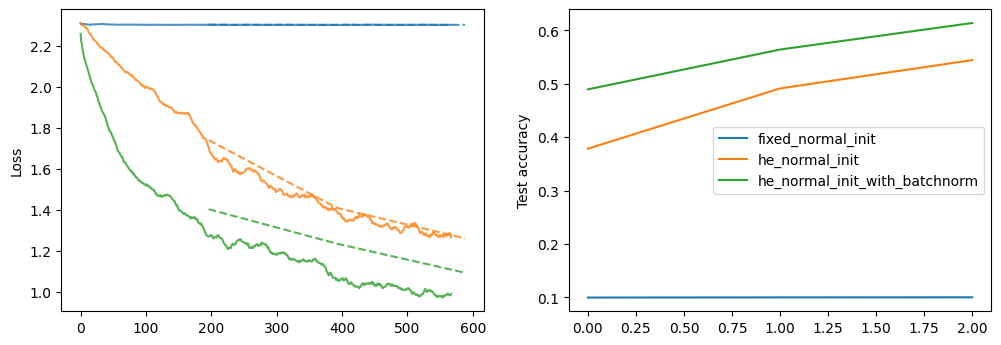

In [8]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

# per step loss values are too noizy, so we'll use a function to 
# average them with a running window
def running_mean(x, win_size):
    return (np.cumsum(x)[win_size:] - np.cumsum(x[:-win_size])) / win_size

for (name, metrics), color in zip(result.items(),
                                  matplotlib.rcParams['axes.prop_cycle'].by_key()['color']):
    ax0.plot(
        running_mean(metrics['train_loss'], 20),
        color=color, label=name, alpha=0.8
    )
    ax0.plot(
        np.linspace(0, len(metrics['train_loss']), len(metrics['test_loss']) + 1)[1:],
        metrics['test_loss'], '--',
        color=color, alpha=0.8
    )
    ax0.set_ylabel("Loss")

    ax1.plot(metrics['test_accuracy'], color=color, label=name)
    ax1.set_ylabel("Test accuracy")

ax1.legend();

## Your turn!

Try improving the score. Since we don't have too much time to train the model thoroughly, see if you can change the model design and/or use regularization layers (batchnorm, dropout) to get better score quicker.

In [0]:
# YOUR CODE HERE
model = 

# E.g.:
#
#     model = ...
#     result['MyModel'] = train_model(model, epochs=..., lr=...)
#
# (and then run the plotting code again)

In [9]:
model_device = next(model.parameters()).device
correct, total = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(model_device), y.to(model_device)

        _, pred = torch.max(model(X).data, 1)

        total += len(y)
        correct += (pred == y).sum().item()

print('accuracy =', correct / total)
assert correct / total >= 0.65

NameError: name 'model' is not defined

In [0]:
model_device = next(model.parameters()).device
correct, total = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(model_device), y.to(model_device)

        _, pred = torch.max(model(X).data, 1)

        total += len(y)
        correct += (pred == y).sum().item()

print('accuracy =', correct / total)
assert correct / total >= 0.7

In [0]:
model_device = next(model.parameters()).device
correct, total = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(model_device), y.to(model_device)

        _, pred = torch.max(model(X).data, 1)

        total += len(y)
        correct += (pred == y).sum().item()

print('accuracy =', correct / total)
assert correct / total >= 0.75